## Importing libraries

In [1]:
import mne
print('MNE-Python version: ', mne.__version__)

import numpy as np
print('Numpy version: ', np.__version__)

import matplotlib.pyplot as plt

import pycrostates
print('Pycrostates version: ', pycrostates.__version__)

import sklearn
print('SKLearn version: ', sklearn.__version__)

mne.set_log_level('error')  # reduce extraneous MNE output

MNE-Python version:  1.4.2
Numpy version:  1.24.3
Pycrostates version:  0.3.0
SKLearn version:  1.2.2


## Importing the preprocessed data

C:\Users\Divya Tiwari\anaconda3\envs\mne\Lib\site-packages\mne\viz\utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


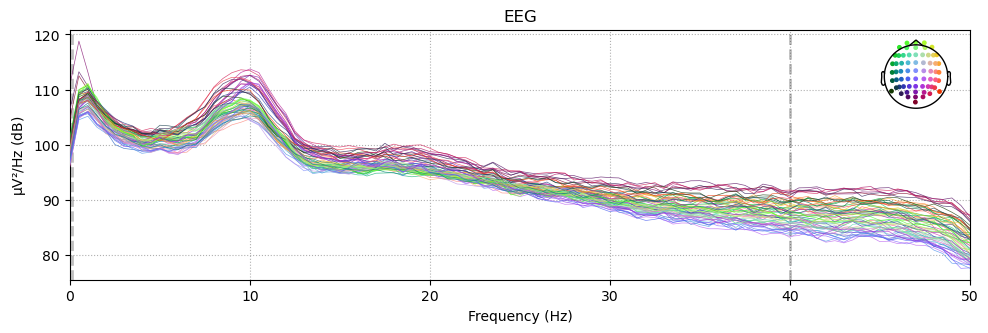

<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, AF7, AF3, F1, F3, F5, F7, FT7, FC5, FC3, FC1, C1, C3, C5, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 lowpass: 40.0 Hz
 meas_date: 2021-08-24 11:04:08 UTC
 meas_id: 4 items (dict)
 nchan: 64
 projs: []
 sfreq: 1024.0 Hz
>

In [2]:
data = mne.io.read_raw_fif("D:\IIIT_Hyderabad\Code\last_files\data.fif", preload = True)
data.plot()
data.plot_psd(fmax = 50)
plt.show()
data.info

In [3]:
data.set_eeg_reference('average')

<Raw | data.fif, 64 x 217088 (212.0 s), ~106.1 MB, data loaded>

In [4]:
tstep = 2.0
events = mne.make_fixed_length_events(data, duration=tstep)
epochs = mne.Epochs(data, events,
                        tmin=0.0, tmax=tstep,
                        baseline=None,
                        preload=True)

### Global Field Power

In [5]:
from pycrostates.preprocessing import extract_gfp_peaks
gfp_data = extract_gfp_peaks(epochs)
gfp_data

< ChData | 6628 samples >

## Modified KMeans

### Evaluating clustering fits

In [6]:
from pycrostates.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    dunn_score,
    davies_bouldin_score,
)


cluster_numbers = range(2, 9)
scores = {
    "Silhouette": np.zeros(len(cluster_numbers)),
    "Calinski-Harabasaz": np.zeros(len(cluster_numbers)),
    "Dunn": np.zeros(len(cluster_numbers)),
    "Davies-Bouldin": np.zeros(len(cluster_numbers)),
}

from pycrostates.cluster import ModKMeans

for k, n_clusters in enumerate(cluster_numbers):
    # fit K-means algorithm with a set number of cluster centers
    ModK = ModKMeans(n_clusters=n_clusters, random_state=42)
    ModK.fit(gfp_data, n_jobs=2, verbose="WARNING")

    # compute scores
    scores["Silhouette"][k] = silhouette_score(ModK)
    scores["Calinski-Harabasaz"][k] = calinski_harabasz_score(ModK)
    scores["Dunn"][k] = dunn_score(ModK)
    scores["Davies-Bouldin"][k] = davies_bouldin_score(ModK)

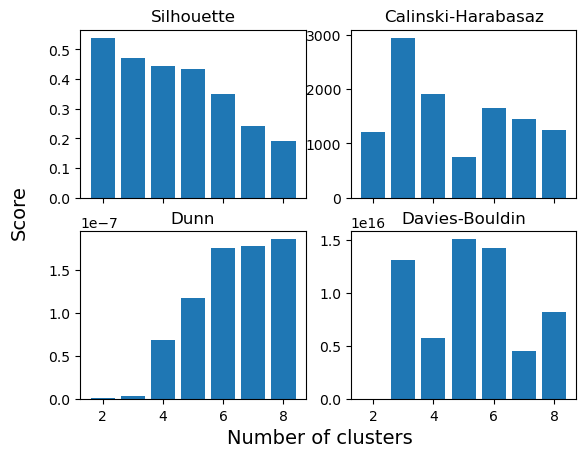

In [7]:
f, ax = plt.subplots(2, 2, sharex=True)
for k, (score, values) in enumerate(scores.items()):
    ax[k // 2, k % 2].bar(x=cluster_numbers, height=values)
    ax[k // 2, k % 2].set_title(score)
plt.text(
    0.03, 0.5, "Score",
    horizontalalignment='center',
    verticalalignment='center',
    rotation=90,
    fontdict=dict(size=14),
    transform=f.transFigure,
)
plt.text(
    0.5, 0.03, "Number of clusters",
    horizontalalignment='center',
    verticalalignment='center',
    fontdict=dict(size=14),
    transform=f.transFigure,
)
plt.show()

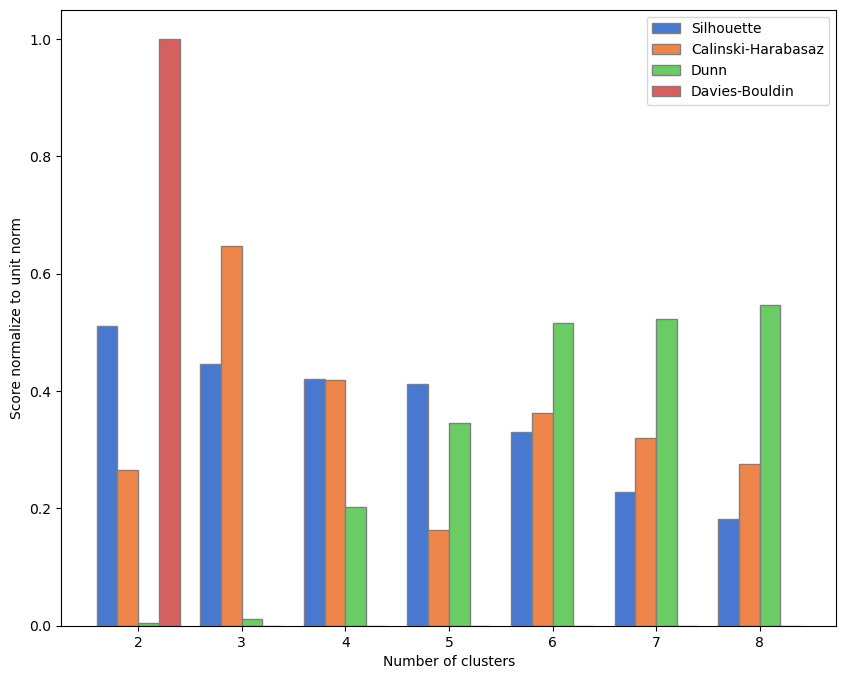

In [8]:
# invert davies-bouldin scores
scores["Davies-Bouldin"] = 1 / (1 + scores["Davies-Bouldin"])

# normalize scores using sklearn
from sklearn.preprocessing import normalize
scores = {score: normalize(value[:, np.newaxis], axis=0).ravel()
          for score, value in scores.items()}

# set width of a bar and define colors
barWidth = 0.2
colors = ["#4878D0", "#EE854A", "#6ACC64", "#D65F5F"]

# create figure
plt.figure(figsize=(10, 8))
# create the position of the bars on the X-axis
x = [[elt + k * barWidth for elt in np.arange(len(cluster_numbers))]
     for k in range(len(scores))]
# create plots
for k, (score, values) in enumerate(scores.items()):
    plt.bar(
        x=x[k],
        height=values,
        width=barWidth,
        edgecolor="grey",
        color=colors[k],
        label=score,
    )
# add labels and legend
plt.xlabel("Number of clusters")
plt.ylabel("Score normalize to unit norm")
plt.xticks(
    [pos + 1.5 * barWidth for pos in range(len(cluster_numbers))],
    [str(k) for k in cluster_numbers],
)
plt.legend()
plt.show()

### For clusters = 4

In [9]:
from pycrostates.cluster import ModKMeans

n_clusters = 4
ModK = ModKMeans(n_clusters=n_clusters,
                 n_init=100, max_iter=300,
                 tol=1e-10, random_state=42)

In [10]:
ModK.fit(gfp_data, n_jobs=4)

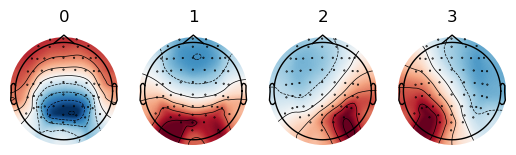

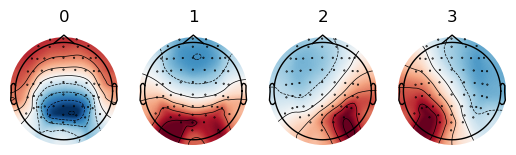

In [11]:
ModK.plot()

In [12]:
ModK.invert_polarity([True, True, False, False])

In [13]:
ModK.GEV_

0.6215523249508824

In [14]:
ModK.reorder_clusters(order=[3, 2, 0, 1])
ModK.rename_clusters(new_names=["A", "B", "C", "D"])

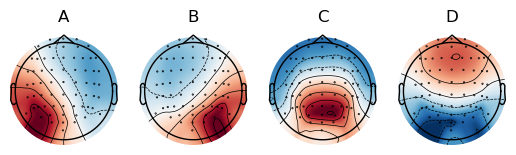

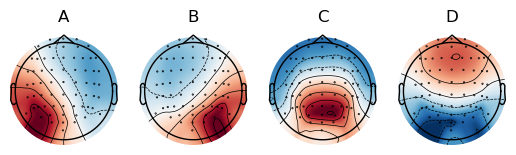

In [15]:
ModK.plot()

In [16]:
segmentation = ModK.predict(
    data,
    reject_by_annotation=True,
    factor=5,
    half_window_size=5,
    min_segment_length=3,
    reject_edges=True,
)

In [17]:
segmentation.labels

array([-1, -1, -1, ..., -1, -1, -1])

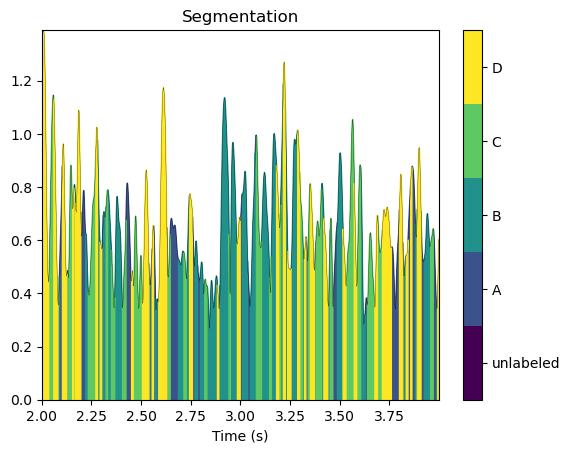

In [18]:
segmentation.plot(tmin = 2, tmax = 4)
plt.show()

In [19]:
parameters = segmentation.compute_parameters()
parameters

{'A_mean_corr': 0.6114110872010404,
 'A_gev': 0.08377276073039433,
 'A_occurrences': 12.271185503600602,
 'A_timecov': 0.22638875450939197,
 'A_meandurs': 0.018448808751441753,
 'B_mean_corr': 0.6535771062258268,
 'B_gev': 0.12005332477444997,
 'B_occurrences': 12.601436555216152,
 'B_timecov': 0.24194298930646357,
 'B_meandurs': 0.01919963555316361,
 'C_mean_corr': 0.6453198639422394,
 'C_gev': 0.1436109399242063,
 'C_occurrences': 12.691076126368943,
 'C_timecov': 0.26999682096504446,
 'C_meandurs': 0.021274541124535317,
 'D_mean_corr': 0.7133275867986583,
 'D_gev': 0.2029484877787297,
 'D_occurrences': 12.860919524342654,
 'D_timecov': 0.2616714352191,
 'D_meandurs': 0.020346246216984592,
 'unlabeled': 0.00018886350235849058}

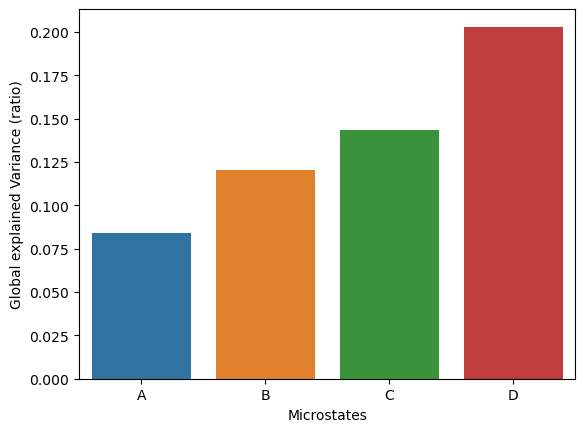

In [20]:
import seaborn as sns
x = ModK.cluster_names
y = [parameters[elt + "_gev"] for elt in x]

ax = sns.barplot(x=x, y=y)
ax.set_xlabel("Microstates")
ax.set_ylabel("Global explained Variance (ratio)")
plt.show()

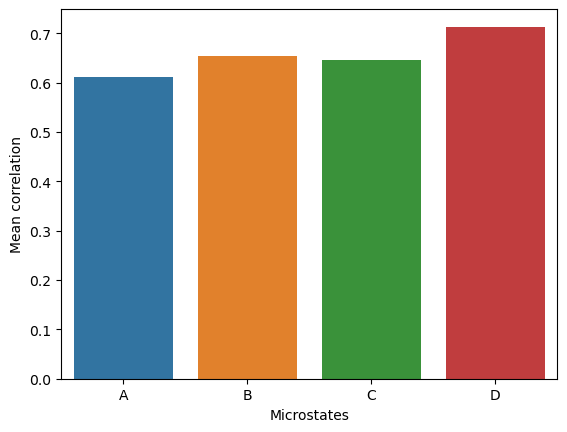

In [21]:
x = ModK.cluster_names
y = [parameters[elt + "_mean_corr"] for elt in x]

ax = sns.barplot(x=x, y=y)
ax.set_xlabel("Microstates")
ax.set_ylabel("Mean correlation")
plt.show()

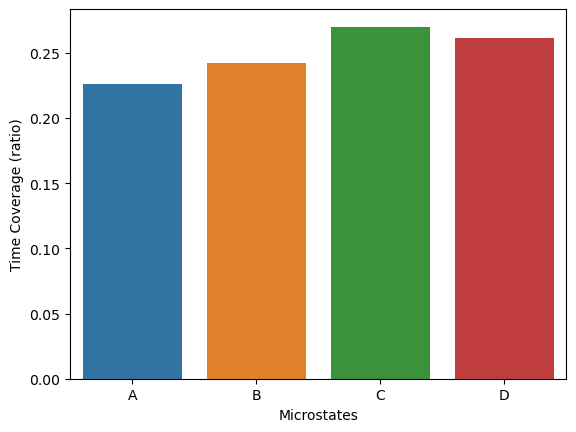

In [24]:
x = ModK.cluster_names
y = [parameters[elt + "_timecov"] for elt in x]

ax = sns.barplot(x=x, y=y)
ax.set_xlabel("Microstates")
ax.set_ylabel("Time Coverage (ratio)")
plt.show()

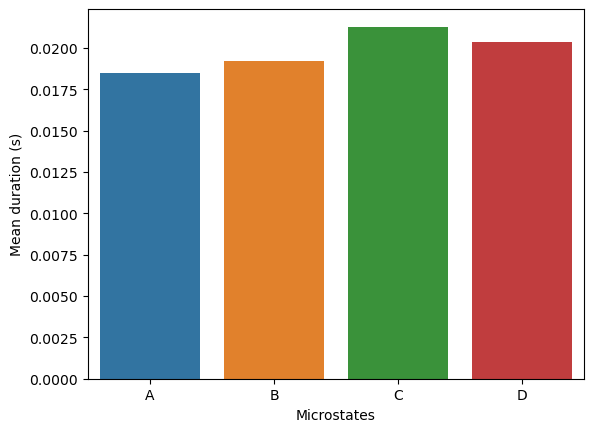

In [25]:
x = ModK.cluster_names
y = [parameters[elt + "_meandurs"] for elt in x]

ax = sns.barplot(x=x, y=y)
ax.set_xlabel("Microstates")
ax.set_ylabel("Mean duration (s)")
plt.show()

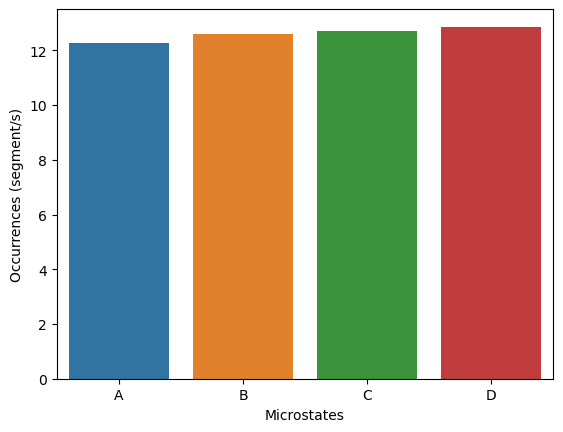

In [26]:
x = ModK.cluster_names
y = [parameters[elt + "_occurrences"] for elt in x]

ax = sns.barplot(x=x, y=y)
ax.set_xlabel("Microstates")
ax.set_ylabel('Occurrences (segment/s)')
plt.show()

In [27]:
parameters = segmentation.compute_parameters(return_dist=True)
parameters

{'A_mean_corr': 0.6114110872010404,
 'A_gev': 0.08377276073039433,
 'A_occurrences': 12.271185503600602,
 'A_timecov': 0.22638875450939197,
 'A_meandurs': 0.018448808751441753,
 'A_dist_corr': array([-0.67225739, -0.69652441, -0.71662864, ...,  0.60438263,
         0.57321453,  0.54039901]),
 'A_dist_gev': array([1.76555317e-06, 1.93534286e-06, 2.09131414e-06, ...,
        7.94122895e-07, 7.37512182e-07, 6.87158620e-07]),
 'A_dist_durs': array([0.01953125, 0.01660156, 0.02929688, ..., 0.01757812, 0.03417969,
        0.03710938]),
 'B_mean_corr': 0.6535771062258268,
 'B_gev': 0.12005332477444997,
 'B_occurrences': 12.601436555216152,
 'B_timecov': 0.24194298930646357,
 'B_meandurs': 0.01919963555316361,
 'B_dist_corr': array([ 0.55481413,  0.58979931,  0.61917341, ..., -0.83132377,
        -0.81420309, -0.79285014]),
 'B_dist_gev': array([1.76787164e-06, 2.07933349e-06, 2.38794467e-06, ...,
        2.33999980e-06, 2.12541476e-06, 1.89421214e-06]),
 'B_dist_durs': array([0.00683594, 0.01

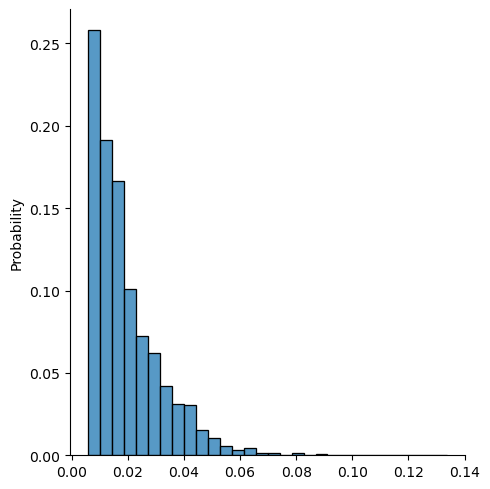

In [28]:
sns.displot(parameters['B_dist_durs'], stat='probability', bins=30)
plt.show()

In [30]:
median = np.median(parameters['D_dist_durs'])
print(f"Microstate D segments have a median duration of {median:.2f}s.")

Microstate D segments have a median duration of 0.02s.


In [31]:
T_observed = segmentation.compute_transition_matrix()

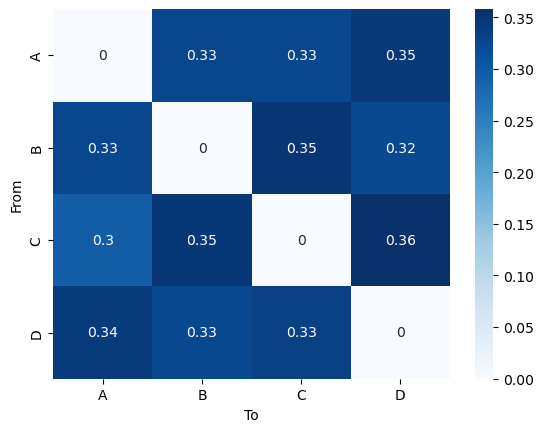

In [32]:
ax = sns.heatmap(
    T_observed,
    annot=True,
    cmap="Blues",
    xticklabels=segmentation.cluster_names,
    yticklabels=segmentation.cluster_names,
)
ax.set_ylabel("From")
ax.set_xlabel("To")
plt.show()

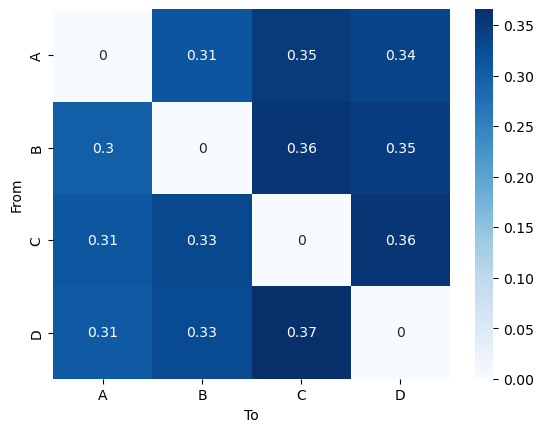

In [33]:
T_expected = segmentation.compute_expected_transition_matrix()
ax = sns.heatmap(
    T_expected,
    annot=True,
    cmap="Blues",
    xticklabels=segmentation.cluster_names,
    yticklabels=segmentation.cluster_names,
)
ax.set_ylabel("From")
ax.set_xlabel("To")
plt.show()

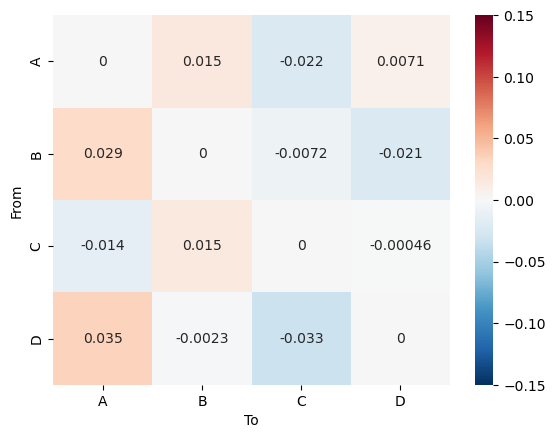

In [34]:
ax = sns.heatmap(
    T_observed - T_expected,
    annot=True,
    cmap="RdBu_r",
    vmin=-0.15,
    vmax=0.15,
    xticklabels=segmentation.cluster_names,
    yticklabels=segmentation.cluster_names,
)
ax.set_ylabel("From")
ax.set_xlabel("To")
plt.show()